In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle
import random
import numpy as np
from asyncio import exceptions

In [3]:
def pickle_load(dir, filename):
  # open a file, where you stored the pickled data
  file = open(os.path.join(dir,filename), 'rb')

  # dump information to that file
  data = pickle.load(file)

  # close the file
  file.close()
  return data

In [4]:
dir = '/content/drive/MyDrive/Colab Notebooks/Pickle'
train_data_x = pickle_load(dir, "train_data_x.pk")
train_data_y = pickle_load(dir, "train_data_y.pk")

test_data_x = pickle_load(dir, "test_data_x.pk")
test_data_y = pickle_load(dir, "test_data_y.pk")

In [5]:
print(train_data_x.shape, train_data_y.shape)
print(test_data_x.shape, test_data_y.shape)

(5000, 100, 100, 3) (5000,)
(1000, 100, 100, 3) (1000,)


In [6]:
img_size = 100
categories = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

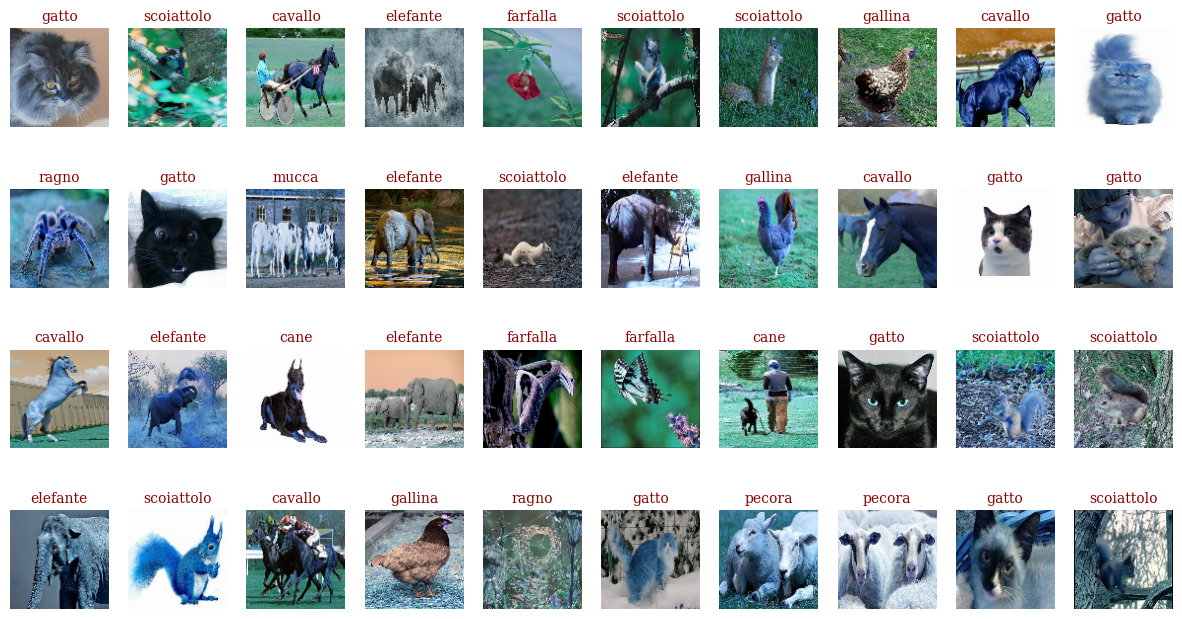

In [7]:
plt.figure(figsize=(15,8))
for i, img in enumerate(train_data_x) :
    plt.subplot(4,10, i+1)
    img = np.reshape(img, (img_size,img_size,3))
    plt.imshow(img)
    plt.axis('off')
    fontdict={'family': 'serif','color':  'darkred','weight': 'normal', 'size': 10,}
    category = categories[train_data_y[i]]
    plt.title(category, fontdict=fontdict)
    if (i+1) == 40:
        break
plt.show()

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_data_x[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_data_x = preprocess_input(train_data_x)
test_data_x = preprocess_input(test_data_x)

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [10]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(10, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
train_data_x, test_data_x = train_data_x/255.0, test_data_x/255.0

In [13]:
model_processed = model
hist = model.fit(x=train_data_x, y=train_data_y, epochs=30, validation_split=0.2, batch_size=128)

Epoch 1/30
32/32 [==============================] - 18s 334ms/step - loss: 1.9048 - accuracy: 0.3433 - val_loss: 1.5731 - val_accuracy: 0.4640
Epoch 2/30
32/32 [==============================] - 5s 146ms/step - loss: 1.3766 - accuracy: 0.5460 - val_loss: 1.2409 - val_accuracy: 0.5980
Epoch 3/30
32/32 [==============================] - 5s 158ms/step - loss: 1.0555 - accuracy: 0.6690 - val_loss: 1.0694 - val_accuracy: 0.6410
Epoch 4/30
32/32 [==============================] - 5s 160ms/step - loss: 0.8405 - accuracy: 0.7408 - val_loss: 0.9857 - val_accuracy: 0.6660
Epoch 5/30
32/32 [==============================] - 5s 161ms/step - loss: 0.7071 - accuracy: 0.7868 - val_loss: 0.9524 - val_accuracy: 0.6690
Epoch 6/30
32/32 [==============================] - 5s 154ms/step - loss: 0.6200 - accuracy: 0.8102 - val_loss: 0.9120 - val_accuracy: 0.6910
Epoch 7/30
32/32 [==============================] - 5s 163ms/step - loss: 0.5415 - accuracy: 0.8380 - val_loss: 0.9113 - val_accuracy: 0.6780
Epoch

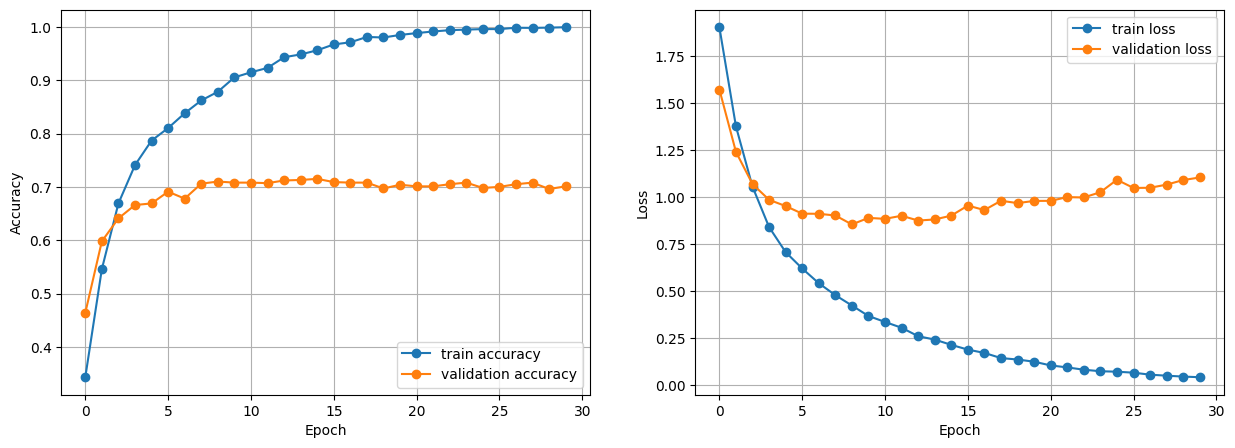

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], 'o-', label='train accuracy')
plt.plot(hist.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], 'o-', label='train loss')
plt.plot(hist.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [15]:
results = model.evaluate(test_data_x, test_data_y, batch_size=128)
print("test loss, test acc:", results)

8/8 [==============================] - 1s 115ms/step - loss: 1.2768 - accuracy: 0.6870
test loss, test acc: [1.2767757177352905, 0.6869999766349792]


In [16]:
predictions = model.predict(test_data_x)

32/32 [==============================] - 2s 47ms/step


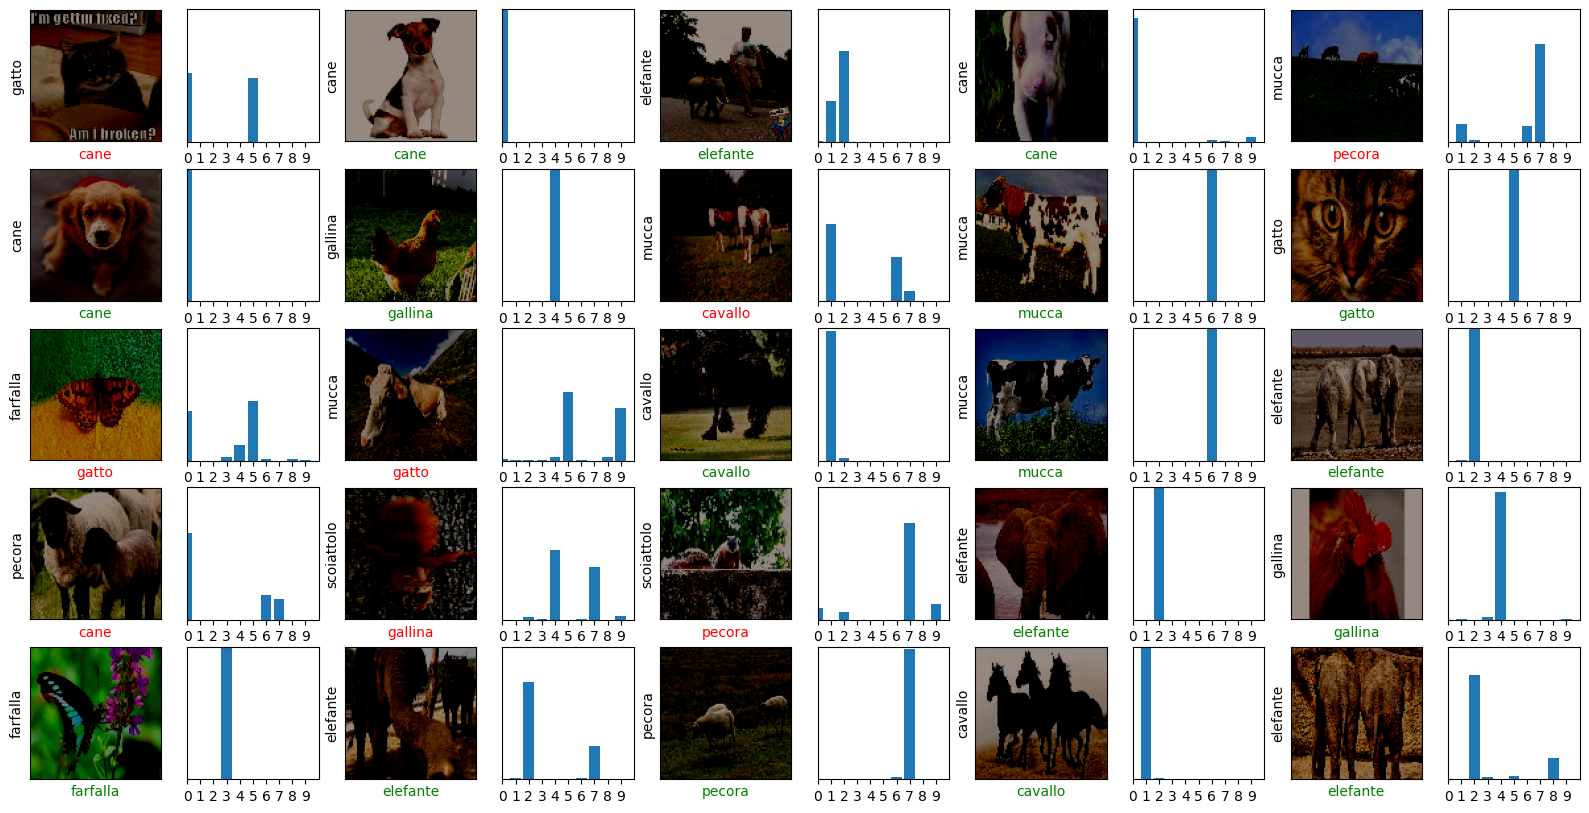

In [17]:
rows = 5
cols = 5

plt.figure(figsize=(20,10))
for i in range(25):

    plt.subplot(rows, 2*cols, 2*i+1)
    plt.imshow(test_data_x[i])
    plt.xticks([])
    plt.yticks([])
    # plt.ylabel(categories[np.argmax(test_data_y[i])])
    plt.ylabel(categories[test_data_y[i]])
    c = np.argmax(predictions[i])
    # if testing_data_y[i][0] == np.argmax(predictions[i]):
    if test_data_y[i] == c:
        plt.xlabel(categories[np.argmax(predictions[i])], color='g')
    else:
        plt.xlabel(categories[np.argmax(predictions[i])], color='r')


    plt.subplot(rows, 2*cols, 2*i+2)
    plt.bar(range(10), predictions[i])
    plt.yticks([])
    plt.xticks(range(0,10))
    plt.ylim([0,1])
    plt.xlim([0,10])

plt.show()